In [ ]:
!pip3 install lightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 442 kB 4.2 MB/s 
     |████████████████████████████████| 585 kB 60.9 MB/s 
     |████████████████████████████████| 151 kB 72.5 MB/s 
     |████████████████████████████████| 79 kB 6.2 MB/s 
     |████████████████████████████████| 117 kB 73.0 MB/s 
     |████████████████████████████████| 596 kB 47.4 MB/s 
     |████████████████████████████████| 140 kB 25.7 MB/s 
     |████████████████████████████████| 419 kB 53.7 MB/s 
     |████████████████████████████████| 1.1 MB 34.4 MB/s 
     |████████████████████████████████| 144 kB 56.3 MB/s 
     |████████████████████████████████| 94 kB 3.7 MB/s 
     |████████████████████████████████| 271 kB 46.6 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144575 sha256=7ac6b4a4a1c87c6c9a70aee128d03887c50e8461c17e6e700a37d05d901823db
  Stored in directory: /roo

In [ ]:
import os
import torch
import torch.nn as nn
import torchvision
import pytorch_lightning as pl
import lightly
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
from PIL import Image
import numpy as np
import copy


/usr/local/lib/python3.7/dist-packages/lightly/cli/train_cli.py:145: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="config", config_name="config")
/usr/local/lib/python3.7/dist-packages/lightly/cli/embed_cli.py:97: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path='config', config_name='config')
/usr/local/lib/python3.7/dist-packages/lightly/cli/upload_cli.py:167: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path='config', config_name='config')
/usr/local/lib/python3.7/dist-packages/lightly/cli/lightly_cli.py:70: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability versio

In [ ]:
from lightly.models.modules.heads import MoCoProjectionHead
from lightly.data import SwaVCollateFunction

from lightly.models.utils import deactivate_requires_grad
from lightly.models.utils import update_momentum
from lightly.models.utils import batch_shuffle
from lightly.models.utils import batch_unshuffle

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jun  8 21:27:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    28W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
path_to_train = '/content/drive/MyDrive/RHEED'
path_to_test = '/content/drive/MyDrive/Train'

In [ ]:
num_workers = 2
batch_size = 256
seed = 1
max_epochs = 50
memory_bank_size = 4096

input_size = 128
num_ftrs = 32

In [ ]:
#!rm -R /content/drive/MyDrive/RHEED/.ipynb_checkpoints

In [ ]:
collate_fn = lightly.data.SimCLRCollateFunction(
    input_size=32,
    gaussian_blur=0.5,
)

In [ ]:
train_classifier_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(32, padding=4),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=lightly.data.collate.imagenet_normalize['mean'],
        std=lightly.data.collate.imagenet_normalize['std'],
    )
])

# No additional augmentations for the test set
test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=lightly.data.collate.imagenet_normalize['mean'],
        std=lightly.data.collate.imagenet_normalize['std'],
    )
])

# We use the moco augmentations for training moco
dataset_train_moco = lightly.data.LightlyDataset(
    input_dir=path_to_train
)

# Since we also train a linear classifier on the pre-trained moco model we
# reuse the test augmentations here (MoCo augmentations are very strong and
# usually reduce accuracy of models which are not used for contrastive learning.
# Our linear layer will be trained using cross entropy loss and labels provided
# by the dataset. Therefore we chose light augmentations.)
dataset_train_classifier = lightly.data.LightlyDataset(
    input_dir=path_to_train,
    transform=train_classifier_transforms
)

dataset_test = lightly.data.LightlyDataset(
    input_dir=path_to_train,
    transform=test_transforms
)
dataset_test2 = lightly.data.LightlyDataset(
    input_dir=path_to_test,
    transform=test_transforms
)

In [ ]:
dataloader_train_moco = torch.utils.data.DataLoader(
    dataset_train_moco,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    drop_last=True,
    num_workers=num_workers
)

dataloader_train_classifier = torch.utils.data.DataLoader(
    dataset_train_classifier,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)
dataloader_test2 = torch.utils.data.DataLoader(
    dataset_test2,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)


In [ ]:
class MocoModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        # create a ResNet backbone and remove the classification head
        resnet = lightly.models.ResNetGenerator('resnet-18', 1, num_splits=8)
        self.backbone = nn.Sequential(
            *list(resnet.children())[:-1],
            nn.AdaptiveAvgPool2d(1),
        )

        # create a moco model based on ResNet
        self.projection_head = MoCoProjectionHead(512, 512, 128)
        self.backbone_momentum = copy.deepcopy(self.backbone)
        self.projection_head_momentum = copy.deepcopy(self.projection_head)
        deactivate_requires_grad(self.backbone_momentum)
        deactivate_requires_grad(self.projection_head_momentum)

        # create our loss with the optional memory bank
        self.criterion = lightly.loss.NTXentLoss(
            temperature=0.1,
            memory_bank_size=memory_bank_size)

    def training_step(self, batch, batch_idx):
        (x_q, x_k), _, _ = batch

        # update momentum
        update_momentum(self.backbone, self.backbone_momentum, 0.99)
        update_momentum(
            self.projection_head, self.projection_head_momentum, 0.99
        )

        # get queries
        q = self.backbone(x_q).flatten(start_dim=1)
        q = self.projection_head(q)

        # get keys
        k, shuffle = batch_shuffle(x_k)
        k = self.backbone_momentum(k).flatten(start_dim=1)
        k = self.projection_head_momentum(k)
        k = batch_unshuffle(k, shuffle)

        loss = self.criterion(q, k)
        self.log("train_loss_ssl", loss)
        return loss

    def training_epoch_end(self, outputs):
        self.custom_histogram_weights()

    # We provide a helper method to log weights in tensorboard
    # which is useful for debugging.
    def custom_histogram_weights(self):
        for name, params in self.named_parameters():
            self.logger.experiment.add_histogram(
                name, params, self.current_epoch)

    def configure_optimizers(self):
        optim = torch.optim.SGD(
            self.parameters(),
            lr=6e-2,
            momentum=0.9,
            weight_decay=5e-4,
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optim, max_epochs
        )
        return [optim], [scheduler]

In [ ]:
class Classifier(pl.LightningModule):
    def __init__(self, backbone):
        super().__init__()
        # use the pretrained ResNet backbone
        self.backbone = backbone

        # freeze the backbone
        deactivate_requires_grad(backbone)

        # create a linear layer for our downstream classification model
        self.fc = nn.Linear(512, 10)

        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        y_hat = self.backbone(x).flatten(start_dim=1)
        y_hat = self.fc(y_hat)
        return y_hat

    def training_step(self, batch, batch_idx):
        x, y, _ = batch
        y_hat = self.forward(x)
        loss = self.criterion(y_hat, y)
        self.log("train_loss_fc", loss)
        return loss

    def training_epoch_end(self, outputs):
        self.custom_histogram_weights()

    # We provide a helper method to log weights in tensorboard
    # which is useful for debugging.
    def custom_histogram_weights(self):
        for name, params in self.named_parameters():
            self.logger.experiment.add_histogram(
                name, params, self.current_epoch
            )

    def validation_step(self, batch, batch_idx):
        x, y, _ = batch
        y_hat = self.forward(x)
        y_hat = torch.nn.functional.softmax(y_hat, dim=1)

        # calculate number of correct predictions
        _, predicted = torch.max(y_hat, 1)
        num = predicted.shape[0]
        correct = (predicted == y).float().sum()
        return num, correct

    def validation_epoch_end(self, outputs):
        # calculate and log top1 accuracy
        if outputs:
            total_num = 0
            total_correct = 0
            for num, correct in outputs:
                total_num += num
                total_correct += correct
            acc = total_correct / total_num
            self.log("val_acc", acc, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        optim = torch.optim.SGD(self.fc.parameters(), lr=30.)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, max_epochs)
        return [optim], [scheduler]

In [ ]:
# use a GPU if available
gpus = 1 if torch.cuda.is_available() else 0

model = MocoModel()
trainer = pl.Trainer(max_epochs=max_epochs, gpus=gpus,
                     progress_bar_refresh_rate=100)
trainer.fit(
    model,
    dataloader_train_moco
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=100)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /content/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                     | Type               | Params
----------------------------------------------------------------
0 | backbone                 | Sequential         | 11.2 M
1 | projection_head  

Training: 0it [00:00, ?it/s]

# Show the Results

In [ ]:
model.eval()
classifier = Classifier(model.backbone)
trainer = pl.Trainer(max_epochs=max_epochs, gpus=gpus,
                     progress_bar_refresh_rate=100)
trainer.fit(
    classifier,
    dataloader_train_classifier,
    dataloader_test
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=100)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | backbone  | Sequential       | 11.2 M
1 | fc        | Linear           | 5.1 K 
2 | criterion | CrossEntropyLoss | 0     
-----------------------------------

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1937: PossibleUserWarning: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
!ls

drive  lightning_logs  sample_data


In [ ]:
#model = torch.load('/content/drive/MyDrive/model.pt')

In [ ]:
import pandas as pd
import seaborn as sns

In [ ]:
# for plotting
import os
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.offsetbox as osb
from matplotlib import rcParams as rcp

# for resizing images to thumbnails
import torchvision.transforms.functional as functional

# for clustering and 2d representations
from sklearn import random_projection

In [ ]:
def get_image_as_np_array(filename: str):
    """Returns an image as an numpy array
    """
    img = Image.open(filename)
    return np.asarray(img)


def plot_knn_examples(embeddings, filenames, n_neighbors=9, num_examples=6):
    """Plots multiple rows of random images with their nearest neighbors
    """
    # lets look at the nearest neighbors for some samples
    # we use the sklearn library
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(embeddings)
    distances, indices = nbrs.kneighbors(embeddings)

    # get 5 random samples
    samples_idx = np.random.choice(len(indices), size=num_examples, replace=False)

    # loop through our randomly picked samples
    for idx in samples_idx:
        fig = plt.figure()
        # loop through their nearest neighbors
        for plot_x_offset, neighbor_idx in enumerate(indices[idx]):
            # add the subplot
            ax = fig.add_subplot(1, len(indices[idx]), plot_x_offset + 1)
            # get the correponding filename for the current index
            fname = os.path.join(path_to_data, filenames[neighbor_idx])
            # plot the image
            plt.imshow(get_image_as_np_array(fname))
            # set the title to the distance of the neighbor
            ax.set_title(f'd={distances[idx][plot_x_offset]:.3f}')
            # let's disable the axis
            plt.axis('off')

In [ ]:
def generate_embeddings(model, dataloader):
    """Generates representations for all images in the dataloader with
    the given mode
    """

    embeddings = []
    filenames = []
    with torch.no_grad():
        for img, label, fnames in dataloader:
            img = img.to('cpu')
            emb = model.backbone(img).cpu().flatten(start_dim=1)
            embeddings.append(emb)
            filenames.extend(fnames)

    embeddings = torch.cat(embeddings, 0)
    embeddings = normalize(embeddings)
    return embeddings, filenames


model.eval()
embeddings, filenames = generate_embeddings(model, dataloader_test)

In [ ]:
# for the scatter plot we want to transform the images to a two-dimensional
# vector space using a random Gaussian projection
projection = random_projection.GaussianRandomProjection(n_components=2)
embeddings_2d = projection.fit_transform(embeddings)

# normalize the embeddings to fit in the [0, 1] square
M = np.max(embeddings_2d, axis=0)
m = np.min(embeddings_2d, axis=0)
embeddings_2d = (embeddings_2d - m) / (M - m)

In [ ]:
df_li = pd.read_csv("/content/drive/MyDrive/Samples/idx_sample.csv")
shown_list = df_li['0']
shown_lists = shown_list.tolist()
type(shown_lists)

list

In [ ]:
embeddings_2d.shape

(2741, 2)

In [ ]:
plot_knn_examples(embeddings, filenames)


Output hidden; open in https://colab.research.google.com to view.

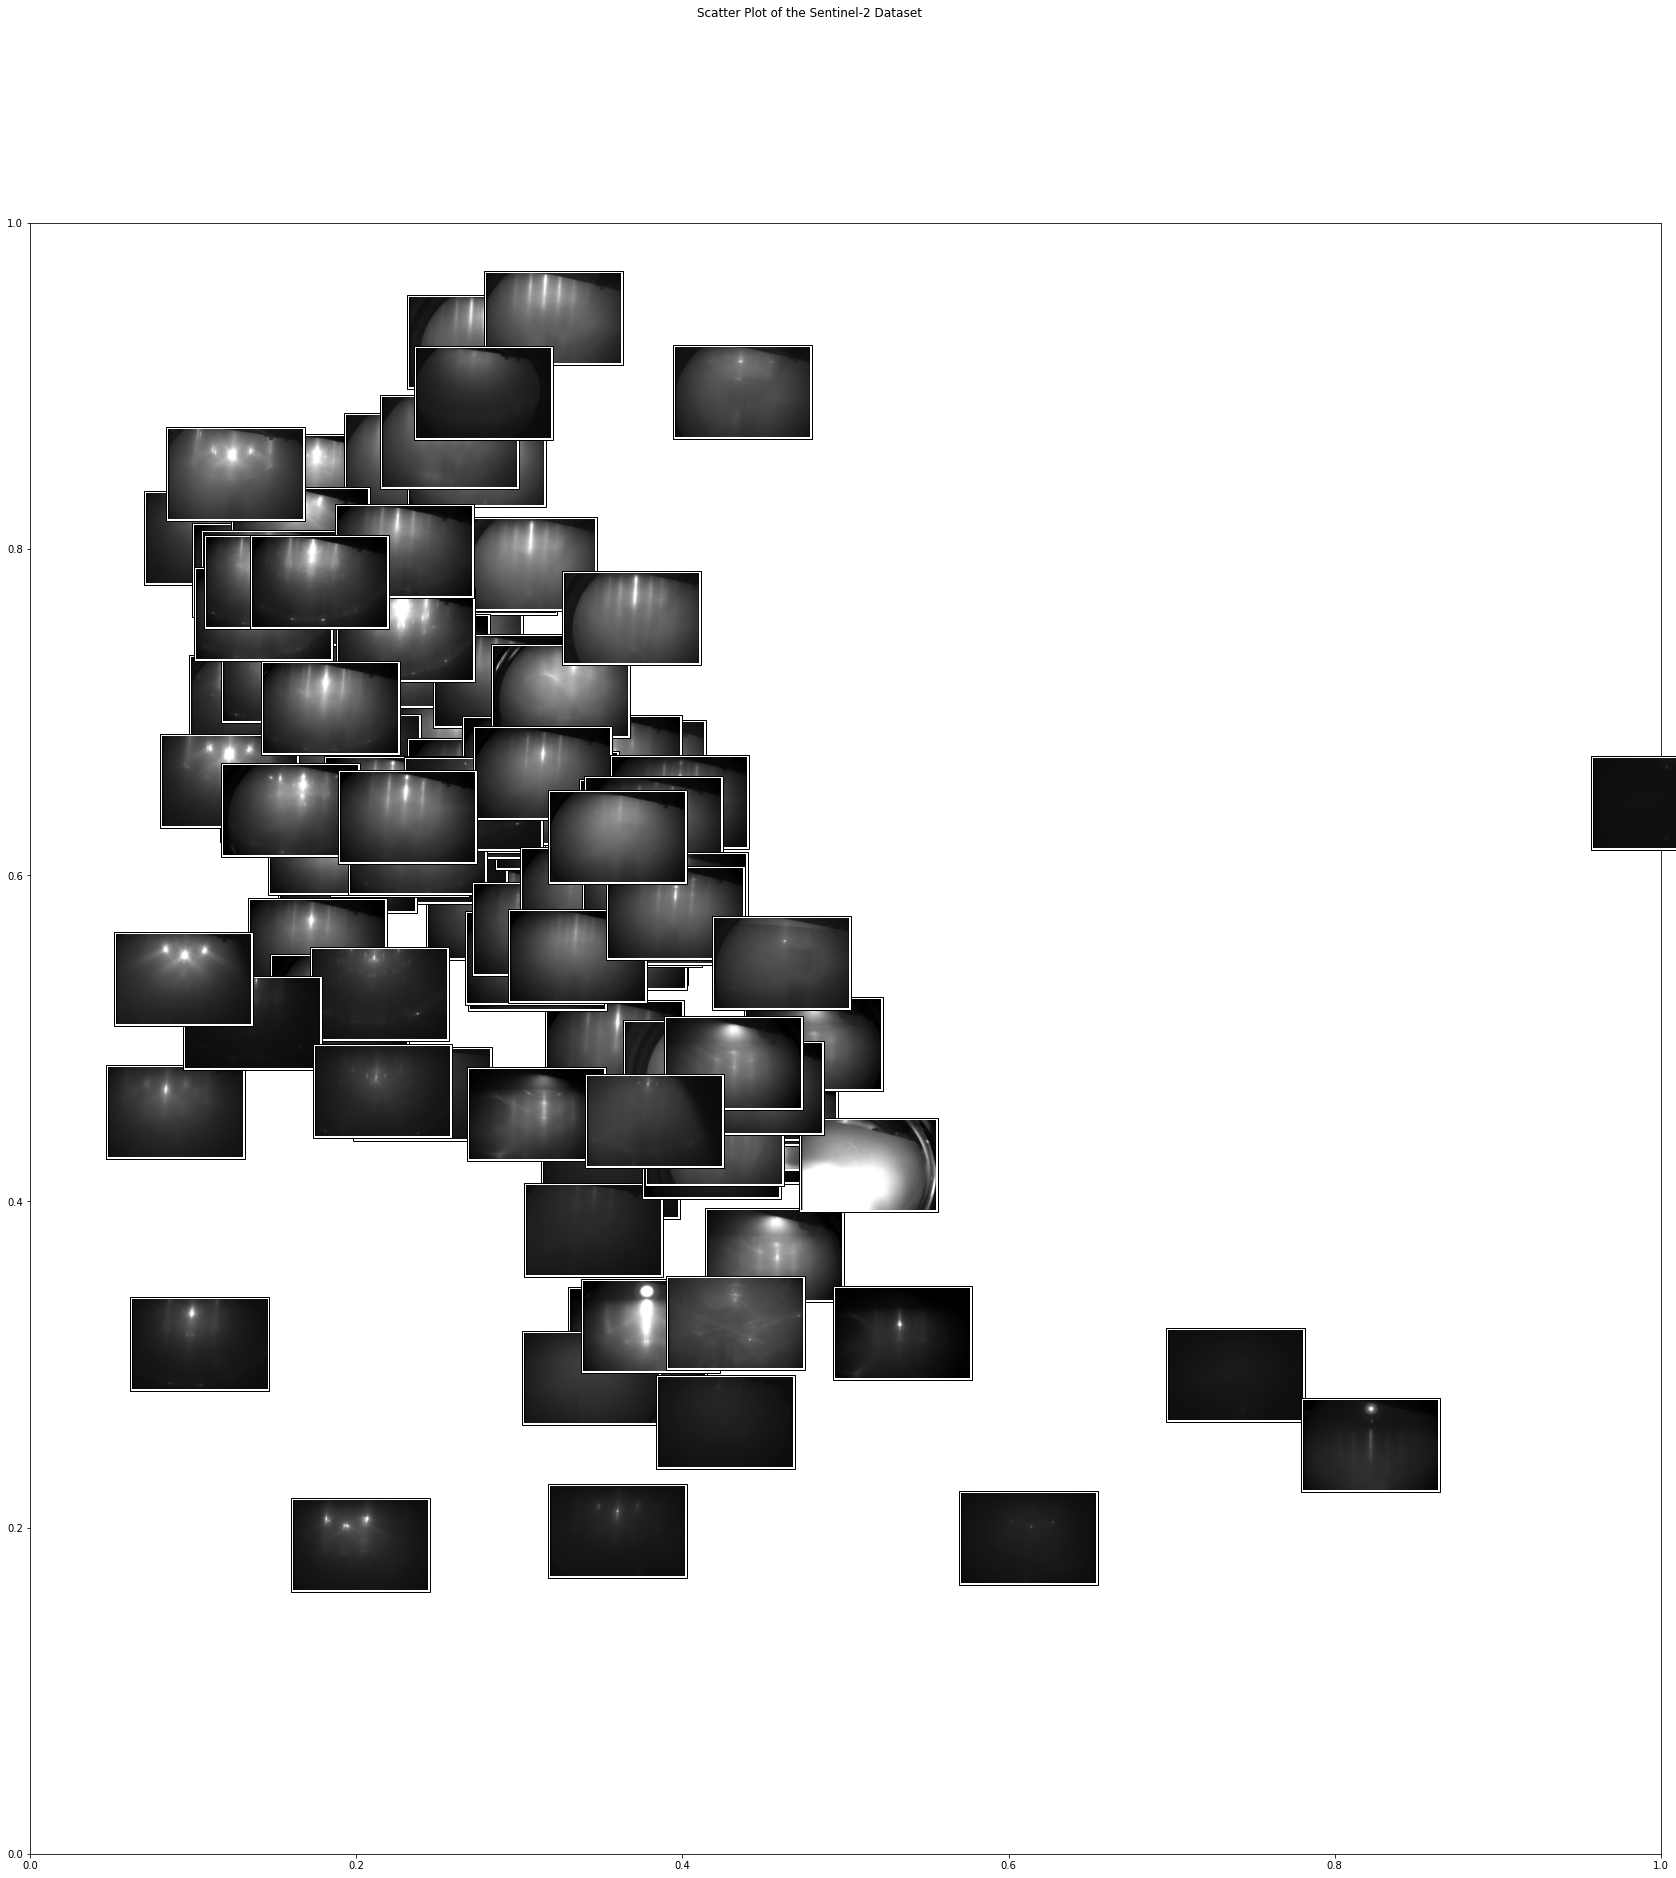

In [ ]:
def get_scatter_plot_with_thumbnails():
    """Creates a scatter plot with image overlays.
    """
    # initialize empty figure and add subplot

    fig = plt.figure()
    fig.set_size_inches(40,30)

    fig.suptitle('Scatter Plot of the Sentinel-2 Dataset')
    ax = fig.add_subplot(1, 1, 1)

    '''
    # shuffle images and find out which images to show
    shown_images_idx = []
    shown_images = np.array([[1., 1.]])
    iterator = [i for i in range(embeddings_2d.shape[0])]
    np.random.seed(0)
    np.random.shuffle(iterator)
    for i in iterator:
        # only show image if it is sufficiently far away from the others
        dist = np.sum((embeddings_2d[i] - shown_images) ** 2, 1)
        #if np.min(dist) < 2e-3:
        #    continue
        shown_images = np.r_[shown_images, [embeddings_2d[i]]]
        shown_images_idx.append(i)
    print(shown_images_idx)
    arr1 = np.array(shown_images_idx)
#    np.save('/content/drive/MyDrive/idx.csv', arr1) 

    # plot image overlays
    filenames_solution=[]

'''
    shown_images_idx = shown_lists
    for idx in shown_images_idx:
        thumbnail_size = int(rcp['figure.figsize'][0] * 15.)
        path = os.path.join(path_to_train, filenames[idx])
        img = Image.open(path)
        img = functional.resize(img, thumbnail_size)
        img = np.array(img)
        img_box = osb.AnnotationBbox(
            osb.OffsetImage(img, cmap=plt.cm.gray_r),
            embeddings_2d[idx],
            pad=0.2,
        )
        ax.add_artist(img_box)
 #       filenames_solution.append(filenames[idx])
#    print(filenames_solution)
#    arr2 = np.array(filenames_solution)
#   np.save('/content/drive/MyDrive/fname.csv', arr2) 




    # set aspect ratio
    ratio = 1. / ax.get_data_ratio()
    ax.set_aspect(ratio, adjustable='box')
#    plt.savefig('/content/drive/MyDrive/Figures/' + 'savefig_default2'+str(max_epochs)+'vr,rr,crop'+'.png')

# get a scatter plot with thumbnail overlays
get_scatter_plot_with_thumbnails()

In [ ]:
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

In [ ]:
df = pd.DataFrame(embeddings_2d, columns=['x','y'])


In [ ]:
non=[]
non = [i for i in range(df.shape[0])]
droper=[]
droper = [x for x in non if x not in shown_lists]

In [ ]:
len(droper)

2609

In [ ]:
df = df.drop(droper)
df = df.reset_index()
df

,index,x,y
0,10,0.191889,0.781183
1,18,0.159414,0.640311
2,33,0.325255,0.713262
3,40,0.379069,0.630194
4,41,0.364629,0.595096
...,...,...,...
127,2624,0.189794,0.523113
128,2629,0.441146,0.463125
129,2653,0.358274,0.494804
130,2663,0.188539,0.616630


In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/Samples/fname_sample - fname_sample.csv')
df2 = df2.drop(['설명: 1x1 1, 2x2 2, 3D 3, poly 4, 그래핀합성전 5, 그래핀6, 그래핀-1x1 7, 1x1 broad 8, flat substrate 9, dot 10, Broad 11'],axis=1)
df2

,Fname,Label,1순서
0,0103_15시43분_Video_1.jpg,1,25
1,0105_23시09분_Video700도어닐후.jpg,7,101
2,0109_19시10분_Video증착4분.jpg,3,64
3,0109_19시38분_Video증착완료.jpg,3,99
4,0109_20시15분_Video600어닐후.jpg,3,85
...,...,...,...
127,1213_18시11분_Video600도 어닐링후 250도 부ᄀ...,7,79
128,1213_19시10분_VideoSe처리2분.jpg,10,39
129,1214_19시02분_Video600도어닐후250도.jpg,8,5
130,1216_15시43분_Video.jpg,7,35


In [ ]:
df2_s = df2

In [ ]:
df2 = df2.sort_values(by=['1순서'], ascending=[True])
df2['Label'] = df2_s['Label']
df2 = df2.reset_index()
df2= df2.drop(['index'],axis=1)
df2

,Fname,Label,1순서
0,0416_14시32분_Video05.jpg,1,2
1,0707_20시28분_Video1-00.jpg,7,3
2,1101_13시34분_Video5.jpg,7,4
3,1214_19시02분_Video600도어닐후250도.jpg,8,5
4,1025_09시19분_Video 30m anneal.jpg,11,6
...,...,...,...
127,1014_21시55분_Video.jpg,9,129
128,1010_16시48분_Video.jpg,11,130
129,0126_17시52분_Video17분.jpg,7,131
130,0425_22시19분_Video07.jpg,1,132


In [ ]:
df['Label'] = df2['Label']
df

,index,x,y,Label
0,10,0.191889,0.781183,1
1,18,0.159414,0.640311,7
2,33,0.325255,0.713262,7
3,40,0.379069,0.630194,8
4,41,0.364629,0.595096,11
...,...,...,...,...
127,2624,0.189794,0.523113,9
128,2629,0.441146,0.463125,11
129,2653,0.358274,0.494804,7
130,2663,0.188539,0.616630,1


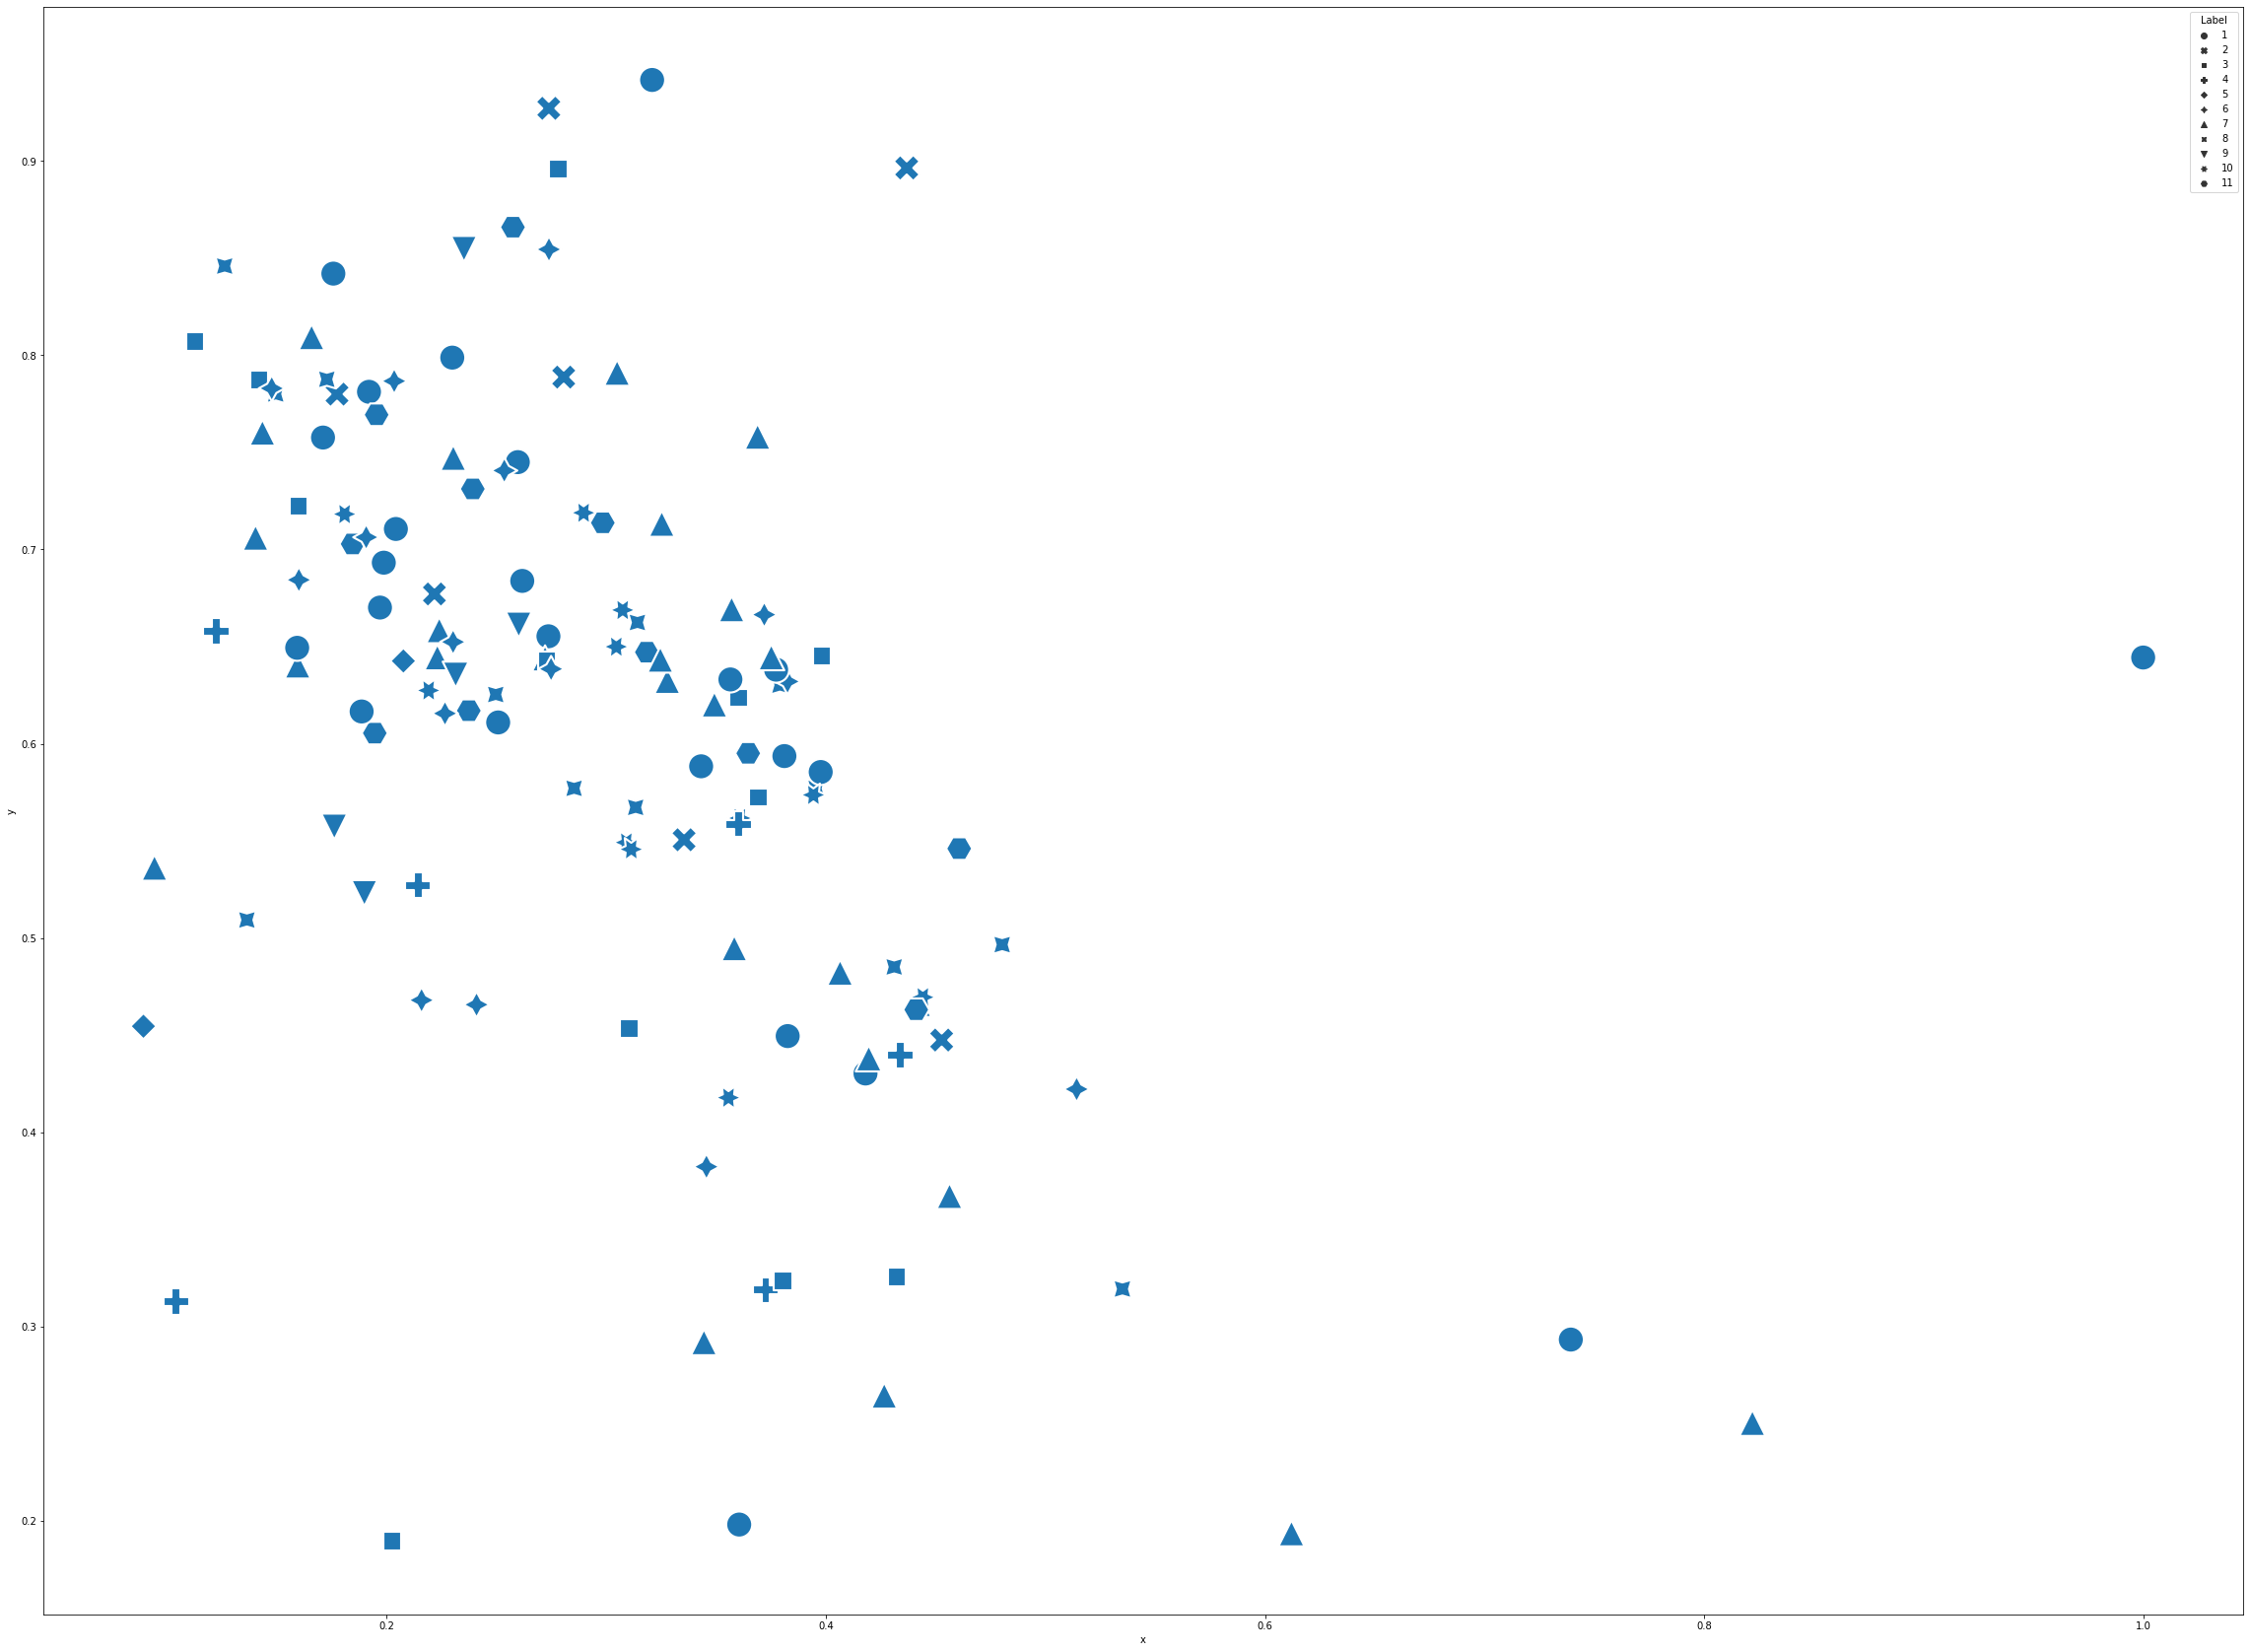

In [ ]:
fig = plt.figure()

ax = sns.scatterplot(x="x",y="y",data=df,style = "Label",s=700)

fig.set_size_inches(40,30)


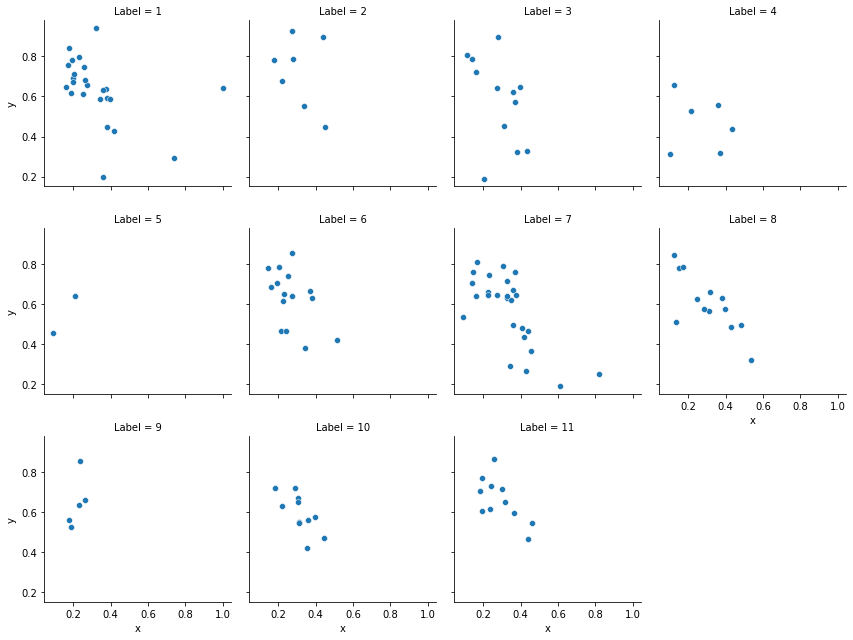

In [ ]:
grid = sns.FacetGrid(data=df, col = "Label",col_wrap=4)
grid.map(sns.scatterplot, "x", "y")

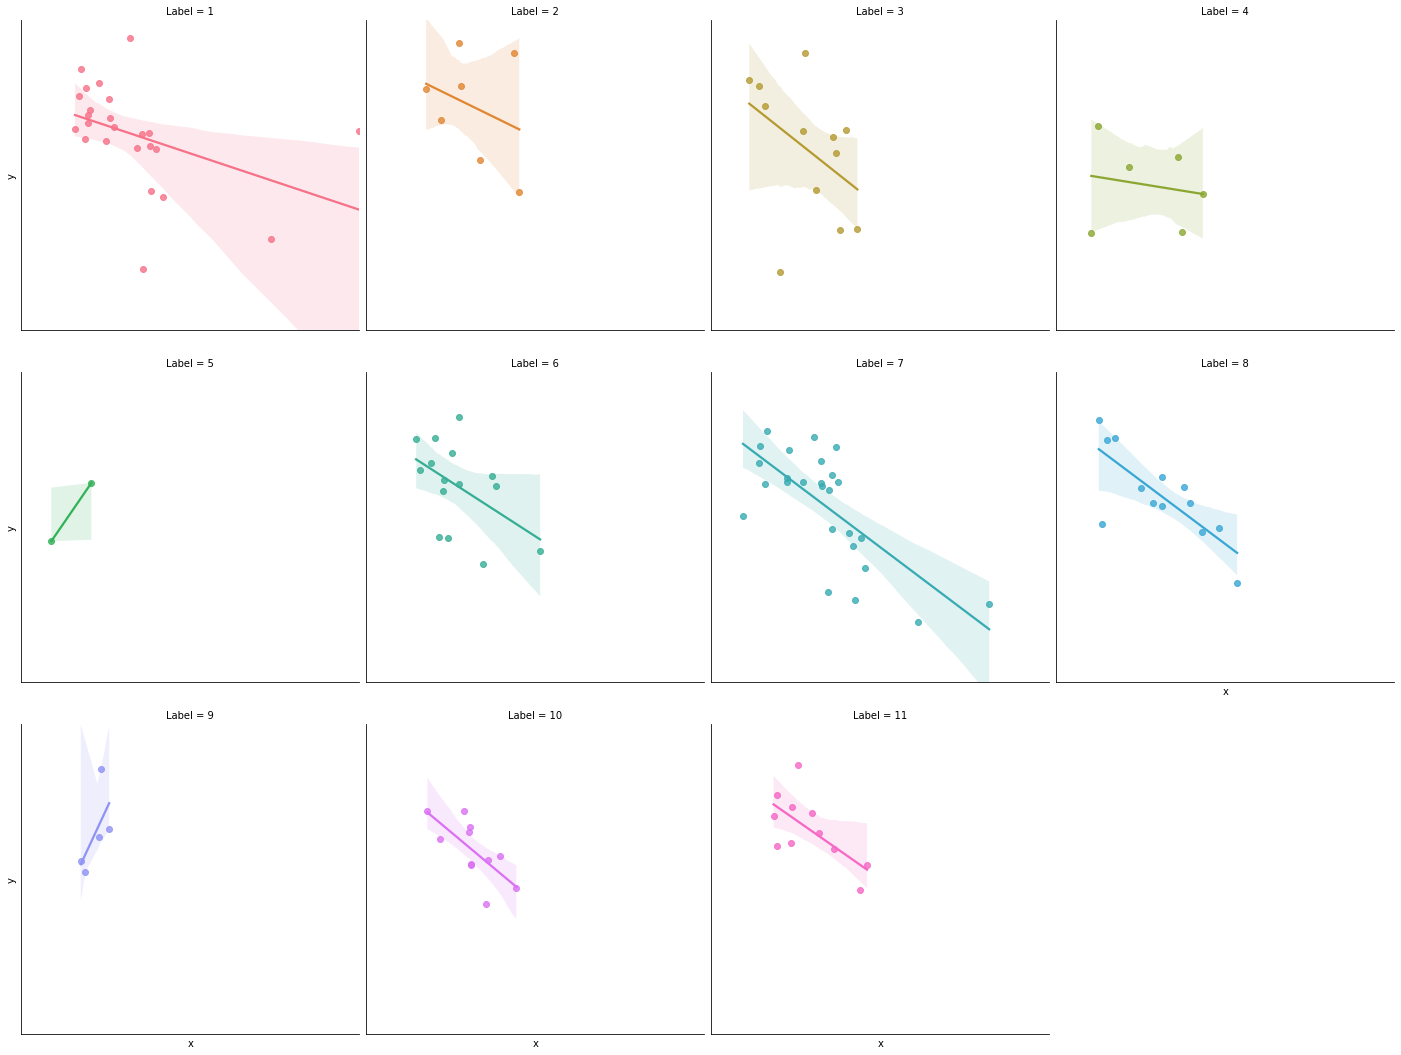

In [ ]:
g = sns.lmplot(x="x", y="y", col="Label", hue="Label",
               data=df, col_wrap=4)
g = (g.set_axis_labels()
      .set(xlim=(0, 1), ylim=(0, 1),
           xticks=[10, 30, 50], yticks=[2, 6, 10])
      .fig.subplots_adjust(wspace=.02))